In [ ]:
# Raw Data Anomaly Detection #

## Import Statements ##

In [2]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from astropy.io import fits
import random
import hdbscan

## Functions to load light curves ##

In [3]:
# Path to the directory containing the FITS files
data_dir = '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'

# Function to load a single FITS file and return as a Pandas DataFrame
def load_light_curve(file_path, band = 1):
    with fits.open(file_path) as hdul:
        data = hdul[1].data  # Assuming light curve data is in the second HDU
        try:
            return pd.DataFrame({
                'TIME': data['TIME'],
                'TIMEDEL': data['TIMEDEL'],
                'RATE': data['RATE'][:, band],  # Use the second energy range
            })
        except KeyError:
            print(f"Skipping file {file_path}: some key not found")
            return None

def load_all_fits_files(data_dir = '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'):
    """
    Loads all fits files
    
    Parameters:
        data_dir (str): The filepath where the data is located
        
    Returns:
        fits_files (list): A list of all the fits files
    """
    
    return glob.glob(os.path.join(data_dir, "*.fits"))

def load_n_light_curves(n, fits_files):
    """
    Loads a specified amount of light curves to analyze.
    
    Parameters:
        n (int): Number of light curves to load.
        fits_files (list): A list of all the fits files
        
    Returns:
        light_curves_1 (list): A list of n light curves in 0.2-0.6 keV,
        light_curves_2 (list): A list of n light curves in 0.6-2.3keV
        light_curves_3 (list): A list of n light curves in 2.3-5.0keV
    """
    

    # R select n files
    fits_files = random.sample(fits_files, n)
    
    # Load all light curves into a list of DataFrames
    light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
    light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
    light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
    
    return light_curves_1, light_curves_2, light_curves_3

def load_all_light_curves(fits_files):
    """
    Loads a specified amount of light curves to analyze.
    
    Parameters:
        n (int): Number of light curves to load.
        fits_files (list): A list of all the fits files
        
    Returns:
        light_curves_1 (list): A list of n light curves in 0.2-0.6 keV,
        light_curves_2 (list): A list of n light curves in 0.6-2.3keV
        light_curves_3 (list): A list of n light curves in 2.3-5.0keV
    """
    

    # Load all light curves into a list of DataFrames
    light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
    light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
    light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
    
    return light_curves_1, light_curves_2, light_curves_3


In [6]:
fits_files = load_all_fits_files()

# light_curves_1_all, light_curves_2_all, light_curves_3_all = load_all_light_curves(fits_files)
# light_curves_1_100, light_curves_2_100, light_curves_3_100 = load_n_light_curves(100, fits_files)
# light_curves_1_400, light_curves_2_400, light_curves_3_400 = load_n_light_curves(400, fits_files)
light_curves_1_1000, light_curves_2_1000, light_curves_3_1000 = load_n_light_curves(1000, fits_files)
# light_curves_1_2000, light_curves_2_2000, light_curves_3_2000 = load_n_light_curves(2000, fits_files)
# light_curves_1_10000, light_curves_2_10000, light_curves_3_10000 = load_n_light_curves(10000, fits_files)
print('Finished Loading Light Curves')

Finished Loading Light Curves


[20.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 20.0]
35.0
19.277
1071
2


<function matplotlib.pyplot.show(close=None, block=None)>

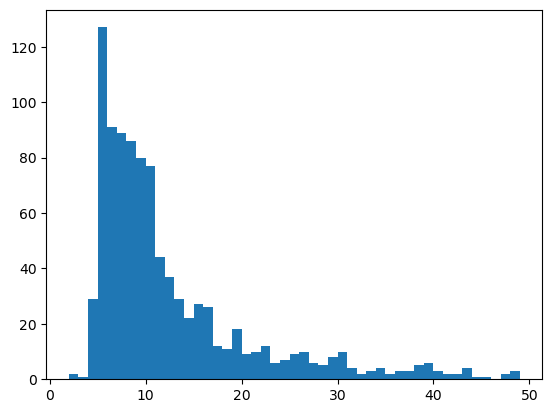

In [8]:
lengths = [len(lc) for lc in light_curves_2_1000]
average = np.average(lengths)
maximum = np.max(lengths)
minimum = np.min(lengths)
print([i for i in light_curves_1_1000[1]["TIMEDEL"]])
print(np.average([i for i in light_curves_1_1000[1]["TIMEDEL"]]))


print(average)
print(maximum)
print(minimum)

binwidth = 1
plt.hist(lengths, bins=range(minimum, 50, binwidth))
plt.show

## Preprocess Data ##

In [81]:
# Interpolate
def interpolate_light_curve(df, num_points=50):
    # Resample TIME and RATE to a fixed number of points
    uniform_times = np.linspace(df['TIME'].min(), df['TIME'].max(), num_points)
    interpolator = interp1d(df['TIME'], df['RATE'], kind='linear', fill_value="extrapolate")
    uniform_rates = interpolator(uniform_times)
    return pd.DataFrame({'TIME': uniform_times, 'RATE': uniform_rates})

# Pad or Truncate
def pad_or_truncate_light_curve(df, target_length=1073):
    current_length = len(df)
    if current_length > target_length:
        # Truncate to the target length
        return df.iloc[:target_length]
    elif current_length < target_length:
        # Pad with zeros for the RATE column
        padding = pd.DataFrame({
            'TIME': np.linspace(
                df['TIME'].max(), 
                df['TIME'].max() + np.mean([i for i in df['TIMEDEL']]) * (target_length - current_length),
                target_length - current_length,
            ),
            'RATE': np.zeros(target_length - current_length, dtype=np.float64)  # Use np.zeros with dtype
        })
        return pd.concat([df, padding], ignore_index=True)
    return df

# def zscore_normalize_rate(df):
#     # Calculate mean and standard deviation of RATE
#     mean_rate = np.mean([i for i in df['RATE']])
#     std_rate =np.std([i for i in df['RATE']])
#     # Normalize using z-score
#     df['RATE'] = (df['RATE'] - mean_rate) / std_rate
#     return df


In [82]:
light_curves = light_curves_2_1000
# processed_normalized_curves = [pad_or_truncate_light_curve(lc) for lc in [zscore_normalize_rate(curve) for curve in light_curves[:]]]
processed_curves = [pad_or_truncate_light_curve(curve) for curve in light_curves[:]]

In [93]:
print(processed_curves[:10])
print('hi')
# print(processed_normalized_curves[:10])

[              TIME  TIMEDEL      RATE
0     6.436385e+08     30.0 -1.070878
1     6.436529e+08     30.0 -0.189044
2     6.436673e+08     50.0 -1.070878
3     6.436817e+08     50.0  1.089968
4     6.436961e+08     40.0 -0.305013
...            ...      ...       ...
1068  6.437512e+08      NaN  0.000000
1069  6.437512e+08      NaN  0.000000
1070  6.437513e+08      NaN  0.000000
1071  6.437513e+08      NaN  0.000000
1072  6.437514e+08      NaN  0.000000

[1073 rows x 3 columns],               TIME  TIMEDEL      RATE
0     6.427032e+08     20.0  2.080190
1     6.427176e+08     40.0 -0.446865
2     6.427320e+08     40.0  0.280419
3     6.427464e+08     40.0 -0.306363
4     6.427608e+08     40.0 -0.869981
...            ...      ...       ...
1068  6.428107e+08      NaN  0.000000
1069  6.428107e+08      NaN  0.000000
1070  6.428107e+08      NaN  0.000000
1071  6.428108e+08      NaN  0.000000
1072  6.428108e+08      NaN  0.000000

[1073 rows x 3 columns],               TIME  TIMEDEL      RA

## HDB Scan Code ##

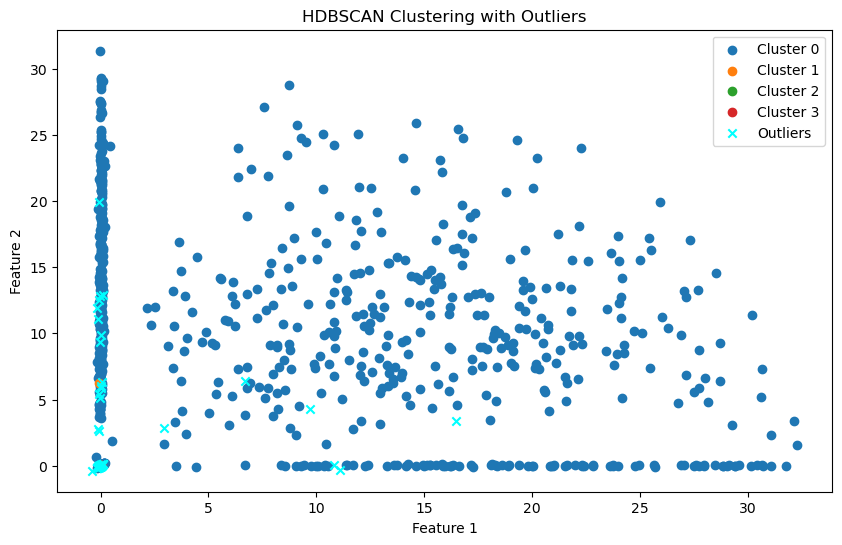

In [50]:
def cluster_light_curves(light_curves):
    normalized_curves = []
    for df in light_curves:
        # Convert to numpy array and ensure native byte order
        rate_array = np.asarray(df['RATE'], dtype=np.float64)
        
        # Standardize
        scaler = StandardScaler()
        normalized_rate = scaler.fit_transform(rate_array.reshape(-1, 1))
        
        normalized_curves.append(normalized_rate.flatten())
    
    X = np.vstack(normalized_curves)
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=3,
        min_samples=3,
        # metric='euclidean',
        # cluster_selection_method='eom'
    )
    
    cluster_labels = clusterer.fit_predict(X)
    #Plotting now
    plt.figure(figsize=(10, 6))

    # Plot regular clusters
    for i in range(4):  # Clusters 0, 1, 2
        mask = cluster_labels == i
        plt.scatter(X[mask, 0], X[mask, 1], 
                   label=f'Cluster {i}')

    # Plot outliers with 'x' marker in cyan
    outlier_mask = cluster_labels == -1
    plt.scatter(X[outlier_mask, 0], X[outlier_mask, 1], 
               c='cyan', marker='x', label='Outliers')

    plt.title('HDBSCAN Clustering with Outliers')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    return cluster_labels, clusterer.outlier_scores_


cluster_labels, outlier_scores_ = cluster_light_curves(processed_curves)


 ## Detect Anomalties Within the Light Curves and Plot ##

In [8]:
def isolation_forest_detector(processed_curves, contamination=0.1):
    # Convert the array of DataFrames to a 2D array of RATE values
    X = np.vstack([curve['RATE'].values for curve in processed_curves])
    
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100
    )
    
    predictions = iso_forest.fit_predict(X)
    return predictions == -1

def lof_detector(processed_curves, n_neighbors=20):
    # Convert the array of DataFrames to a 2D array of RATE values
    X = np.vstack([curve['RATE'].values for curve in processed_curves])
    
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination='auto'
    )
    
    predictions = lof.fit_predict(X)
    return predictions == -1

def plot_anomalies(processed_curves, anomaly_mask):
    plt.figure(figsize=(12, 6))
    
    # Plot each curve with appropriate color based on its anomaly status
    for i, curve in enumerate(processed_curves):
        if anomaly_mask[i]:
            plt.plot(curve['TIME'], curve['RATE'], 'r-', linewidth=2, alpha=0.7, label='Anomaly' if i == 0 else "")
        else:
            plt.plot(curve['TIME'], curve['RATE'], 'b-', alpha=0.3, label='Normal' if i == 0 else "")
    
    plt.xlabel('Time')
    plt.ylabel('Rate')
    plt.title('Light Curve Anomaly Detection')
    plt.legend()
    plt.show()



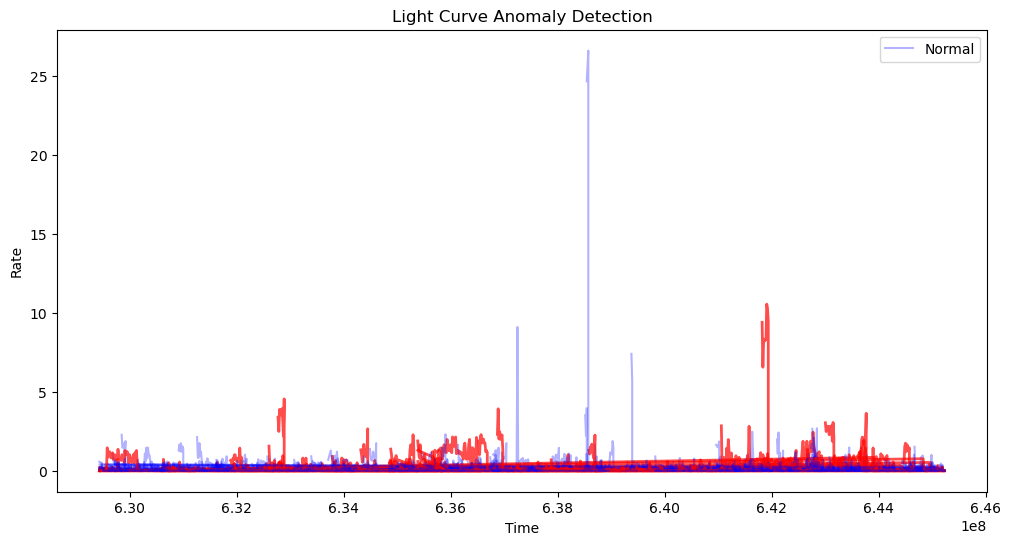

In [16]:
# Detect anomalies
anomalies_iso = isolation_forest_detector(processed_curves)
anomalies_lof = lof_detector(processed_curves)

# Visualize results
plot_anomalies(processed_curves, anomalies_iso)


In [83]:
def combined_analysis(processed_curves, contamination=0.1, n_neighbors=20):
    # Get anomaly predictions
    iso_forest_anomalies = isolation_forest_detector(processed_curves, contamination)
    lof_anomalies = lof_detector(processed_curves, n_neighbors)
    
    # Perform HDBSCAN clustering with PCA
    X = np.vstack([curve['RATE'].values for curve in processed_curves])
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=3)
    cluster_labels = hdbscan_clusterer.fit_predict(X_reduced)
    
    return X_reduced, cluster_labels, iso_forest_anomalies, lof_anomalies


def plot_combined_analysis_with_outlier_legend(processed_curves, X_reduced, cluster_labels, anomaly_mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Create custom colormap that reserves gray for outliers
    unique_labels = np.unique(cluster_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels[unique_labels != -1])))
    
    # Plot 1: HDBSCAN Clustering
    for label in unique_labels:
        mask = cluster_labels == label
        if label == -1:
            ax1.scatter(X_reduced[mask, 0], X_reduced[mask, 1], 
                       c='gray', label='Outlier', alpha=0.6)
        else:
            ax1.scatter(X_reduced[mask, 0], X_reduced[mask, 1], 
                       c=[colors[label]], label=f'Cluster {label}', 
                       alpha=0.6)
    
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.set_title('HDBSCAN Clustering of Light Curves')
    ax1.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot 2: Anomaly Detection
    normal = ax2.plot(processed_curves[0]['TIME'], processed_curves[0]['RATE'], 
                     'b-', alpha=0.3, label='Normal')[0]
    anomaly = ax2.plot(processed_curves[0]['TIME'], processed_curves[0]['RATE'], 
                      'r-', linewidth=2, alpha=0.7, label='Anomaly')[0]
    
    for i, curve in enumerate(processed_curves):
        if anomaly_mask[i]:
            ax2.plot(curve['TIME'], curve['RATE'], 'r-', 
                    linewidth=2, alpha=0.7)
        else:
            ax2.plot(curve['TIME'], curve['RATE'], 'b-', 
                    alpha=0.3)

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Rate')
    ax2.set_title('Light Curve Anomaly Detection')
    ax2.legend(title="Legend")

    plt.tight_layout()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


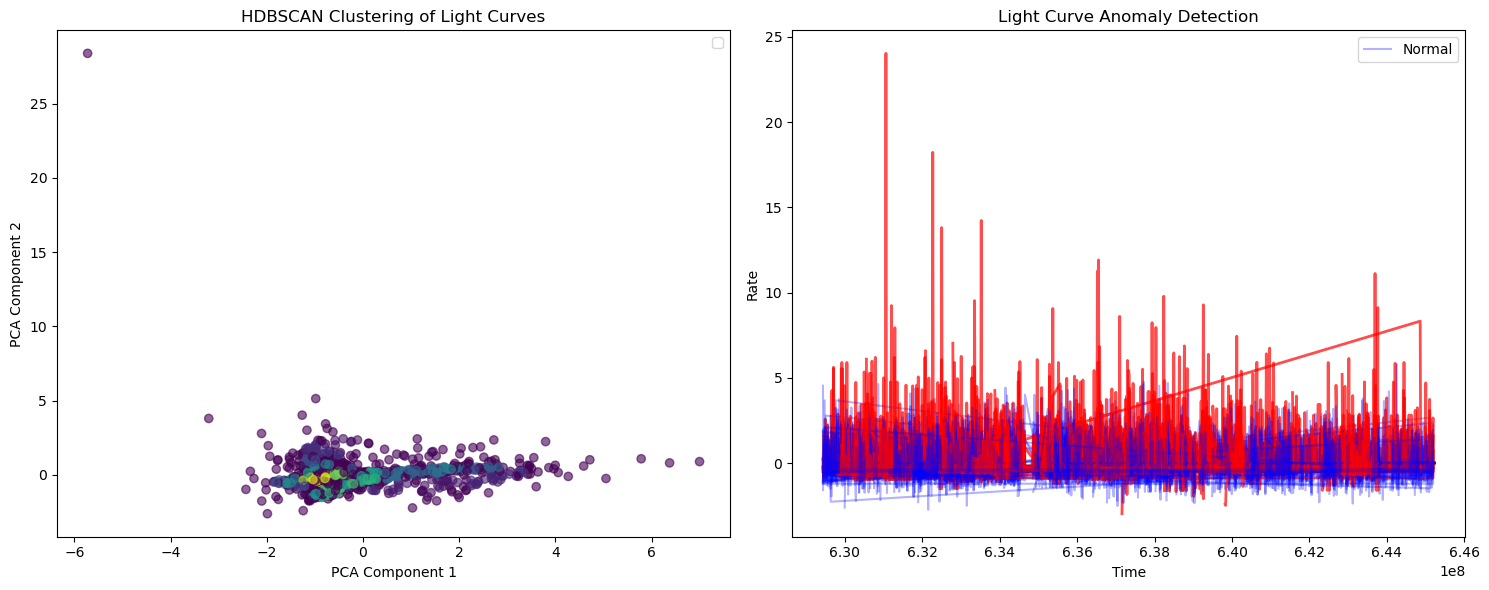

In [84]:
# Usage:
X_reduced, cluster_labels, anomalies_iso, anomalies_lof = combined_analysis(processed_curves)
plot_combined_analysis(processed_curves, X_reduced, cluster_labels, anomalies_iso)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


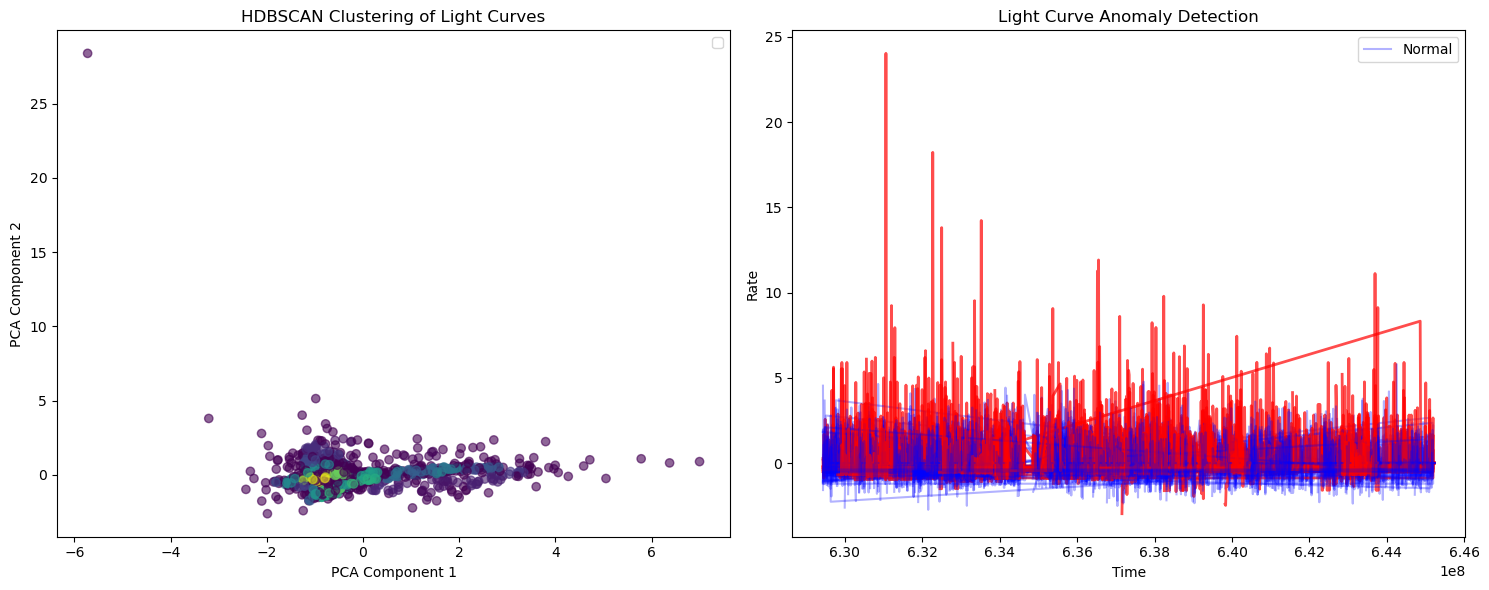

In [85]:
# Usage:
# X_reduced1, cluster_labels1, anomalies_iso1, anomalies_lof1 = combined_analysis(processed_normalized_curves)
# plot_combined_analysis(processed_normalized_curves, X_reduced1, cluster_labels1, anomalies_iso1)